# Quick Jupyter Notebook to show properties of Lie Algebras!

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import interact, FloatSlider


# What is a Rotation Matrix? 

You can kind of think of a rotation matrix as a something that takes a vector and returns a new vector that is rotated about an axis by some angle

<img src="./images/rotation.png" width="300">

In [63]:
def plot_rotation(angle):
    theta = np.deg2rad(angle)
    # Create rotation matrix
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    # Original vector
    x = np.array([1, 0])
    x_rotated = R @ x
    x_rotated_transposed = R.T @ x_rotated * 0.5
    
    # Create figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
    
    # Plot vectors
    ax1.arrow(0, 0, x[0], x[1], head_width=0.05, head_length=0.1, 
              fc='blue', ec='blue', linewidth=2, label='x')
    ax1.arrow(0, 0, x_rotated[0], x_rotated[1], head_width=0.05, 
              head_length=0.1, fc='red', ec='red', linewidth=2, 
              label='R @ x')
    ax1.arrow(0, 0, x_rotated_transposed[0], x_rotated_transposed[1], head_width=0.05, 
              head_length=0.1, fc='green', ec='green', linewidth=2, label='R.T @ x')
    
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_aspect('equal')
    ax1.grid(False)
    ax1.legend()
    ax1.set_title(f'Vector Rotation (θ = {angle:.2f} degress)')
    
    im = ax2.imshow(R, cmap='gray', vmin=-100, vmax=1)
    ax2.set_title('Rotation Matrix')
    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(['x', 'y'])
    ax2.set_yticklabels(['x', 'y'])

    im = ax3.imshow(R.T, cmap='gray', vmin=-100, vmax=1)
    ax3.set_title('Rotation Matrix Transposed')
    ax3.set_xticks([0, 1])
    ax3.set_yticks([0, 1])
    ax3.set_xticklabels(['x', 'y'])
    ax3.set_yticklabels(['x', 'y'])
    
    # Add matrix values as text
    for i in range(2):
        for j in range(2):
            ax2.text(j, i, f'{R[i,j]:.2f}', 
                    ha='center', va='center', color='black')
            ax3.text(j, i, f'{R.T[i,j]:.2f}', 
                    ha='center', va='center', color='black')
    
    plt.tight_layout()
    plt.show()

# Create interactive widget
interact(plot_rotation, 
         angle=FloatSlider(min=0, max=360, step=0.1, 
                          value=90, description='θ (degrees)'))

interactive(children=(FloatSlider(value=90.0, description='θ (degrees)', max=360.0), Output()), _dom_classes=(…

<function __main__.plot_rotation(angle)>

In [56]:
from scipy.linalg import expm, logm

def generate_SO3_from_lie_algebra(psi):
    """
    Generate a member of SO(3) using the matrix exponential of a Lie algebra.
    :param psi: Lie algebra vector
    :return: Rotation matrix in SO(3)
    """
    skew_matrix = vector_to_skew_symmetric(psi)
    return expm(skew_matrix)
  
def generate_lie_algebra_from_SO3(rotation: np.ndarray) -> np.ndarray:
    """
    Generate a Lie algebra vector from a rotation matrix in SO(3).

    :param rotation: A 3x3 rotation matrix (SO(3))
    :return: Lie algebra vector (psi)
    """
    # Compute the logarithm of the rotation matrix
    skew_matrix = logm(rotation)

    # Extract the Lie algebra vector from the skew-symmetric matrix
    return skew_symmetric_to_vector(skew_matrix)


def vector_to_skew_symmetric(v: np.ndarray) -> np.ndarray:
    """
    :param v: vector
    :return: skew symmetric matrix from a vector
    """
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]], dtype=np.float32)
  
def skew_symmetric_to_vector(skew: np.ndarray) -> np.ndarray:
    """
    :param skew: skew symmetric matrix
    :return: vector from a skew symmetric matrix
    """
    return np.array([skew[2, 1], skew[0, 2], skew[1, 0]], dtype=np.float32)

    
def extract_lie_algebra(rotation: np.ndarray) -> np.ndarray:
    """
    Extract the Lie algebra vector (psi) from a rotation matrix by converting it to an axis-angle representation.

    :param rotation: A 3x3 rotation matrix (SO(3))
    :return: Lie algebra vector (psi = theta * phi), where:
             - theta is the rotation angle
             - phi is the unit vector representing the axis of rotation
    """
    # Compute the trace of the rotation matrix
    traceR = (np.trace(rotation) - 1.0) / 2.0  # cos(theta)

    # Clamp traceR to the range [-1, 1] to handle numerical precision issues
    traceR = np.clip(traceR, -1.0, 1.0)

    # Compute the rotation angle (theta) using the arccosine of traceR
    theta = math.acos(traceR)

    # Handle the case where theta is very small (near zero rotation)
    if np.isclose(theta, 0):
        return np.zeros(3, dtype=np.float32)

    # Compute the skew-symmetric matrix (Lie algebra)
    skew_matrix = (rotation - rotation.T) / (2 * math.sin(theta))

    # Convert the skew-symmetric matrix to a vector
    psi = theta * skew_symmetric_to_vector(skew_matrix)
    return psi


def generate_rotation_matrix(psi: np.ndarray) -> np.ndarray:
    """
    Generate a rotation matrix from a Lie algebra vector using Rodrigues' formula.

    :param psi: Lie algebra vector (3D)
    :return: Rotation matrix (3x3)
    """
    theta = np.linalg.norm(psi)  # Magnitude of rotation (angle)
    if theta == 0:
        return np.eye(3)  # Return identity matrix for zero rotation

    phi = psi / theta  # Axis of rotation (unit vector)
    skew_phi = vector_to_skew_symmetric(phi)  # Skew-symmetric matrix of phi

    # Rodrigues' rotation formula
    R = (
        np.cos(theta) * np.eye(3) +
        (1 - np.cos(theta)) * np.outer(phi, phi) +
        np.sin(theta) * skew_phi
    )
    return R


Test that these 2 ways of generating Rotations and Lie Algebras are equivalent.

In [40]:
# simple rotation by 90 degrees around z-axis
ground_truth_rotation = np.array([[0.0, -1.0, 0.0],
                                  [1.0, 0.0, 0.0],
                                  [0.0, 0.0, 1.0]], dtype=np.float32)

# generate Lie algebra from rotation using matrix logarithm
lie_algebra = generate_lie_algebra_from_SO3(ground_truth_rotation)
lie_algebra_2 = extract_lie_algebra(ground_truth_rotation)

assert np.allclose(lie_algebra, lie_algebra_2), "Lie algebra extraction failed"

# now assert that we can generate the rotation matrix back from the Lie algebra
rotation_from_lie_algebra = generate_rotation_matrix(lie_algebra)
rotation_from_lie_algebra_2 = generate_SO3_from_lie_algebra(lie_algebra)
assert np.allclose(rotation_from_lie_algebra, ground_truth_rotation, rtol=1e-6, atol=1e-5), "Rotation matrix generation failed"# now assert that we can generate the Lie algebra back from the rotation matrix using the exponential map
assert np.allclose(rotation_from_lie_algebra_2, ground_truth_rotation, rtol=1e-6, atol=1e-5), "Rotation matrix generation from Lie algebra failed"

def format_matrix(matrix: np.ndarray) -> str:
    return np.array2string(
        matrix,
        precision=2,          # Number of decimal places
        suppress_small=True,  # Suppress small values (e.g., 1e-10) to 0
        separator=', ',       # Separator between elements
        floatmode='fixed'     # Fixed-point notation
    )
        
# Define the variables and their values
data = {
    'Variable': ['Rotation Matrix', 'Lie Algebra', 'Lie Algebra (Extracted)', 'Rotation Matrix from Lie Algebra', 'Rotation Matrix from Lie Algebra (Exponential Map)'],
    'Value': [
        format_matrix(ground_truth_rotation),
        lie_algebra,
        lie_algebra_2,
        format_matrix(rotation_from_lie_algebra),
        format_matrix(rotation_from_lie_algebra_2)
    ]
}
# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
])

/var/folders/4z/11q9sv6x7254_8j19w7_kpt80000gr/T/ipykernel_72030/2042346487.py:20: RuntimeWarning: logm result may be inaccurate, approximate err = 1.13370710153049e-07
  skew_matrix = logm(rotation)


,Variable,Value
0,Rotation Matrix,"[[ 0.00, -1.00, 0.00], [ 1.00, 0.00, 0.00], [ 0.00, 0.00, 1.00]]"
1,Lie Algebra,[0. 0. 1.5707963]
2,Lie Algebra (Extracted),[0. 0. 1.5707964]
3,Rotation Matrix from Lie Algebra,"[[ 0.00, -1.00, 0.00], [ 1.00, 0.00, 0.00], [ 0.00, 0.00, 1.00]]"
4,Rotation Matrix from Lie Algebra (Exponential Map),"[[ 0.00, -1.00, 0.00], [ 1.00, 0.00, 0.00], [ 0.00, 0.00, 1.00]]"


# Now we will give an example of trying to optimize the following function 
|| Gx - Rx ||


where x is a vector in $R^3$ and G is a matrix in $R^{3x3}$ and R is a rotation matrix in $R^{3x3}$. 

basically we want to get a rotation that minimizes the distance between Gx and Rx.. we will see that without converting to a lie algebra we can't do unconstrained optimization.

In [4]:
from scipy.optimize import minimize

# --------------------------
# Lie-based Optimization Loop
# --------------------------
def optimize_rotation_with_lie(G, x, max_iters=10, tol=1e-8):
    
    # --------------------------
    # Objective function: minimizes ||Gx - R_updated x||
    # R_updated = exp(skew(delta_psi)) @ R_current
    # --------------------------
    def objective_function_with_lie(delta_psi, G, x, R_current):
        # delta_R = generate_SO3_from_lie_algebra(delta_psi)  # local rotation update
        delta_R = generate_rotation_matrix(delta_psi)  # local rotation update
        R_updated = delta_R @ R_current  # apply local update
        return np.linalg.norm(G @ x - R_updated @ x)

    R_current = np.eye(3)
    
    for i in range(max_iters):
        delta_psi_init = np.zeros(3)
        
        result = minimize(
            objective_function_with_lie,
            delta_psi_init,
            args=(G, x, R_current),
            method='trust-constr',
            options={'verbose': 0}
        )
        
        delta_psi = result.x
        delta_norm = np.linalg.norm(delta_psi)
        
        # Convergence check
        if delta_norm < tol:
            print(f"Converged at iteration {i+1} (delta norm = {delta_norm:.2e})")
            break
        # delta_R = generate_SO3_from_lie_algebra(delta_psi)
        delta_R = generate_rotation_matrix(delta_psi)
        R_current = delta_R @ R_current
    
    return R_current

# --------------------------
# Optimization Without Lie Algebra
# (No rotation matrix constraints, so result may not be perfectly orthogonal)
# --------------------------
def optimize_rotation_without_lie(G, x):
    # --------------------------
    # Objective function: minimizes ||Gx - Rx|| directly
    # R is optimized as a flat vector (9 elements)
    # --------------------------
    def objective_function_without_lie(R_flat, G, x):
        R = R_flat.reshape((3, 3))
        return np.linalg.norm(G @ x - R @ x)

    # Initial guess: slightly perturbed identity matrix
    R_init = np.eye(3) + np.random.uniform(-0.05, 0.05, size=(3, 3)).astype(np.float32)
    R_init_flat = R_init.flatten()

    result = minimize(
        objective_function_without_lie,
        R_init_flat,
        args=(G, x),
        method='trust-constr',
        options={'verbose': 0}
    )

    R_optimized = result.x.reshape((3, 3))
    return R_optimized

In [5]:
# --------------------------
# Example Inputs
# --------------------------
# make a random rotation matrix

# Generate random Euler angles (in radians)
euler_angles = np.random.uniform(low=-np.pi, high=np.pi, size=3)  # yaw, pitch, roll

# Create rotation object using 'zyx' order (yaw, pitch, roll)
rotation = R.from_euler('zyx', euler_angles)

# Convert to rotation matrix
G = rotation.as_matrix()
# randomly generate a vector
# Generate a random 3D vector
x = np.random.uniform(-1, 1, size=3).astype(np.float32)
x = x / np.linalg.norm(x)

# --------------------------
# Run Both Optimizations
# --------------------------
R_with_lie = optimize_rotation_with_lie(G, x)
R_without_lie = optimize_rotation_without_lie(G, x)

# --------------------------
# Print Results
# --------------------------

# Optionally compare norms or error
error_with_lie = np.linalg.norm(G @ x - R_with_lie @ x)
error_without_lie = np.linalg.norm(G @ x - R_without_lie @ x)

print(f"\nError (with Lie algebra): {error_with_lie:.6f}")
print(f"Error (without Lie algebra): {error_without_lie:.6f}")

def check_SO3(R):
    """
    Check if a matrix is in SO(3).
    :param R: Rotation matrix
    :return: True if R is in SO(3), False otherwise
    """
    determinant_is_1 = np.isclose(np.linalg.det(R), 1.0)
    orthogonal = np.allclose(R @ R.T, np.eye(3))
    if not orthogonal:
        print("R @ R.T:\n", R @ R.T)
        print("R @ R.T - I:\n", R @ R.T - np.eye(3))
    if not determinant_is_1:
        print("det(R):", np.linalg.det(R))
        print("det(R) - 1:", np.linalg.det(R) - 1)
    return orthogonal and determinant_is_1

Converged at iteration 3 (delta norm = 0.00e+00)

Error (with Lie algebra): 0.000000
Error (without Lie algebra): 0.000000


In [6]:
import matplotlib.pyplot as plt

def plot_single_rotation(title, ax, x, R, color):

    full_title = f"{title}\n(R^TR == I ? {np.allclose(np.eye(3), R.T @ R, rtol=1e-5, atol=1e-5)})\n(det(R) = {np.linalg.det(R):.2f} == 1 ? {np.isclose(np.linalg.det(R), 1)})"
    ax.set_title(full_title)

    max_val = 1.2 * max(np.linalg.norm(x), np.linalg.norm(R))
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])
    ax.set_zlim([-max_val, max_val])

    # Plot origin
    ax.scatter([0], [0], [0], color='k')

    # Plot original vector x
    ax.quiver(0, 0, 0, *x, color='gray', label='Original x', linewidth=2)

    # Plot transformed vector
    ax.quiver(0, 0, 0, *R @ x, color=color, label='Transformed x', linewidth=2)

    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")



[[ 9.99999981e-01 -8.81217013e-09  8.77552539e-09]
 [-8.81217013e-09  9.99999993e-01  1.07734087e-09]
 [ 8.77552539e-09  1.07734087e-09  1.00000002e+00]]


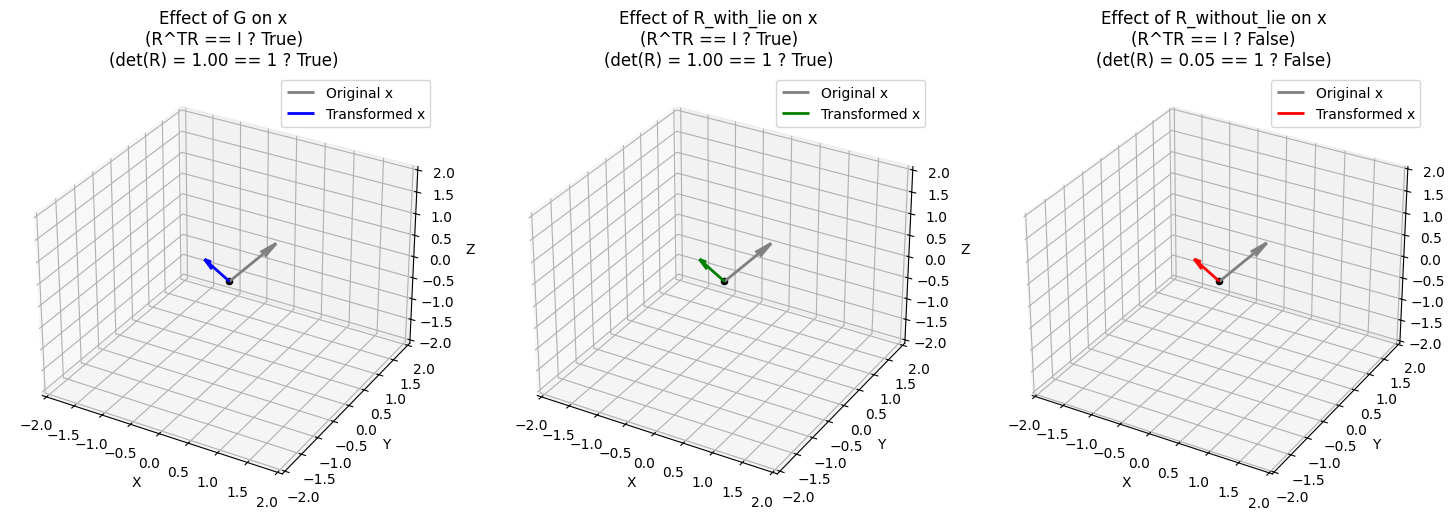

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(15, 5))

print(R_with_lie.T @ R_with_lie)
# Plot each one
plot_single_rotation("Effect of G on x", ax1, x, G, 'blue')
plot_single_rotation("Effect of R_with_lie on x", ax2, x, R_with_lie, 'green')
plot_single_rotation("Effect of R_without_lie on x", ax3, x, R_without_lie, 'red')
plt.tight_layout()
plt.show()